In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import conv2d, conv3d
from scipy.ndimage import convolve, generate_binary_structure
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Ising Model

The Ising model describes a system of spins on a lattice, where each spin can have a value of either -1 or +1. The total energy of a configuration in the Ising model is given by:

$$ E_\mu = \sum_{\langle i,j \rangle} -J \sigma_i \sigma_j $$

<p align="center">
  <img src="/images/detailed_balance.png" alt="drawing" width="400" align="center"/>
</p>

Here, $\sigma_i$ represents the spin value at site $i$ on the lattice, and the sum $\sum_{\langle i,j \rangle}$ is taken over pairs of nearest-neighbor spins. The parameter $J$ represents the interaction strength between adjacent spins.

## Detailed Balance Condition

To ensure that the system reaches equilibrium, we need to satisfy the detailed balance condition. The detailed balance condition states that the rate of transition between two states $\mu$ and $\nu$ should be balanced when the system is in equilibrium:

$$ p_\mu P(\mu \to \nu) = p_\nu P(\nu \to \mu) $$


In the Ising model, we can simplify this condition using the probabilities $p_\mu$ and $p_\nu$ defined earlier:

$$ \frac{p_\nu}{p_\mu} = \frac{P(\mu \to \nu)}{P(\nu \to \mu)} = e^{-\beta (E_\nu - E_\mu)} $$

<p align="center">
  <img src="/images/ising_model.png" alt="drawing" width="400" align="center"/>
</p>


Here, $\beta = \frac{1}{kT}$ is the inverse temperature, and $k$ is the Boltzmann constant.

## Metropolis Algorithm

The Metropolis algorithm is a Monte Carlo method used to simulate the Ising model and reach an equilibrium state. The algorithm proceeds as follows:

1. Initialize the lattice with random spin values.
2. Choose a random spin site on the lattice and flip its spin. The resulting configuration is denoted as $\nu$.
3. Calculate the energy difference between the new configuration $\nu$ and the current configuration $\mu$: $\Delta E = E_\nu - E_\mu$.
4. If $\Delta E \leq 0$, accept the new configuration $\nu$ as the current configuration with probability 1.
5. If $\Delta E > 0$, accept the new configuration $\nu$ as the current configuration with probability $e^{-\beta \Delta E}$.
6. Update the current configuration to $\nu$ or keep the current configuration as $\mu$ based on the acceptance probabilities.
7. Repeat steps 2-6 for a sufficient number of iterations or until equilibrium is reached.

By repeatedly applying the Metropolis algorithm, the system will eventually settle into an equilibrium state described by the Boltzmann distribution, where the probability of each configuration $\mu$ is given by:

$$ p_\mu = \frac{1}{Z} e^{-\beta E_\mu} $$


Here, $Z$ is the partition function defined as $Z = \sum_\mu e^{-\beta E_\mu}$, which ensures normalization of the probabilities.


In [2]:
# generate a random 2D Ising model (1000x1000)
N = 1000

In [3]:
# generating random grids
init_random = torch.rand((N, N)).to(device) # generates a grid with maximum negative spins
lattice_n = torch.zeros((N, N)).to(device)
lattice_n[init_random > 0.75] = 1
lattice_n[init_random <= 0.75] = -1

init_random = torch.rand((N, N)).to(device) # generates a grid with maximum negative spins
lattice_p = torch.zeros((N, N)).to(device)
lattice_p[init_random > 0.25] = 1
lattice_p[init_random <= 0.25] = -1

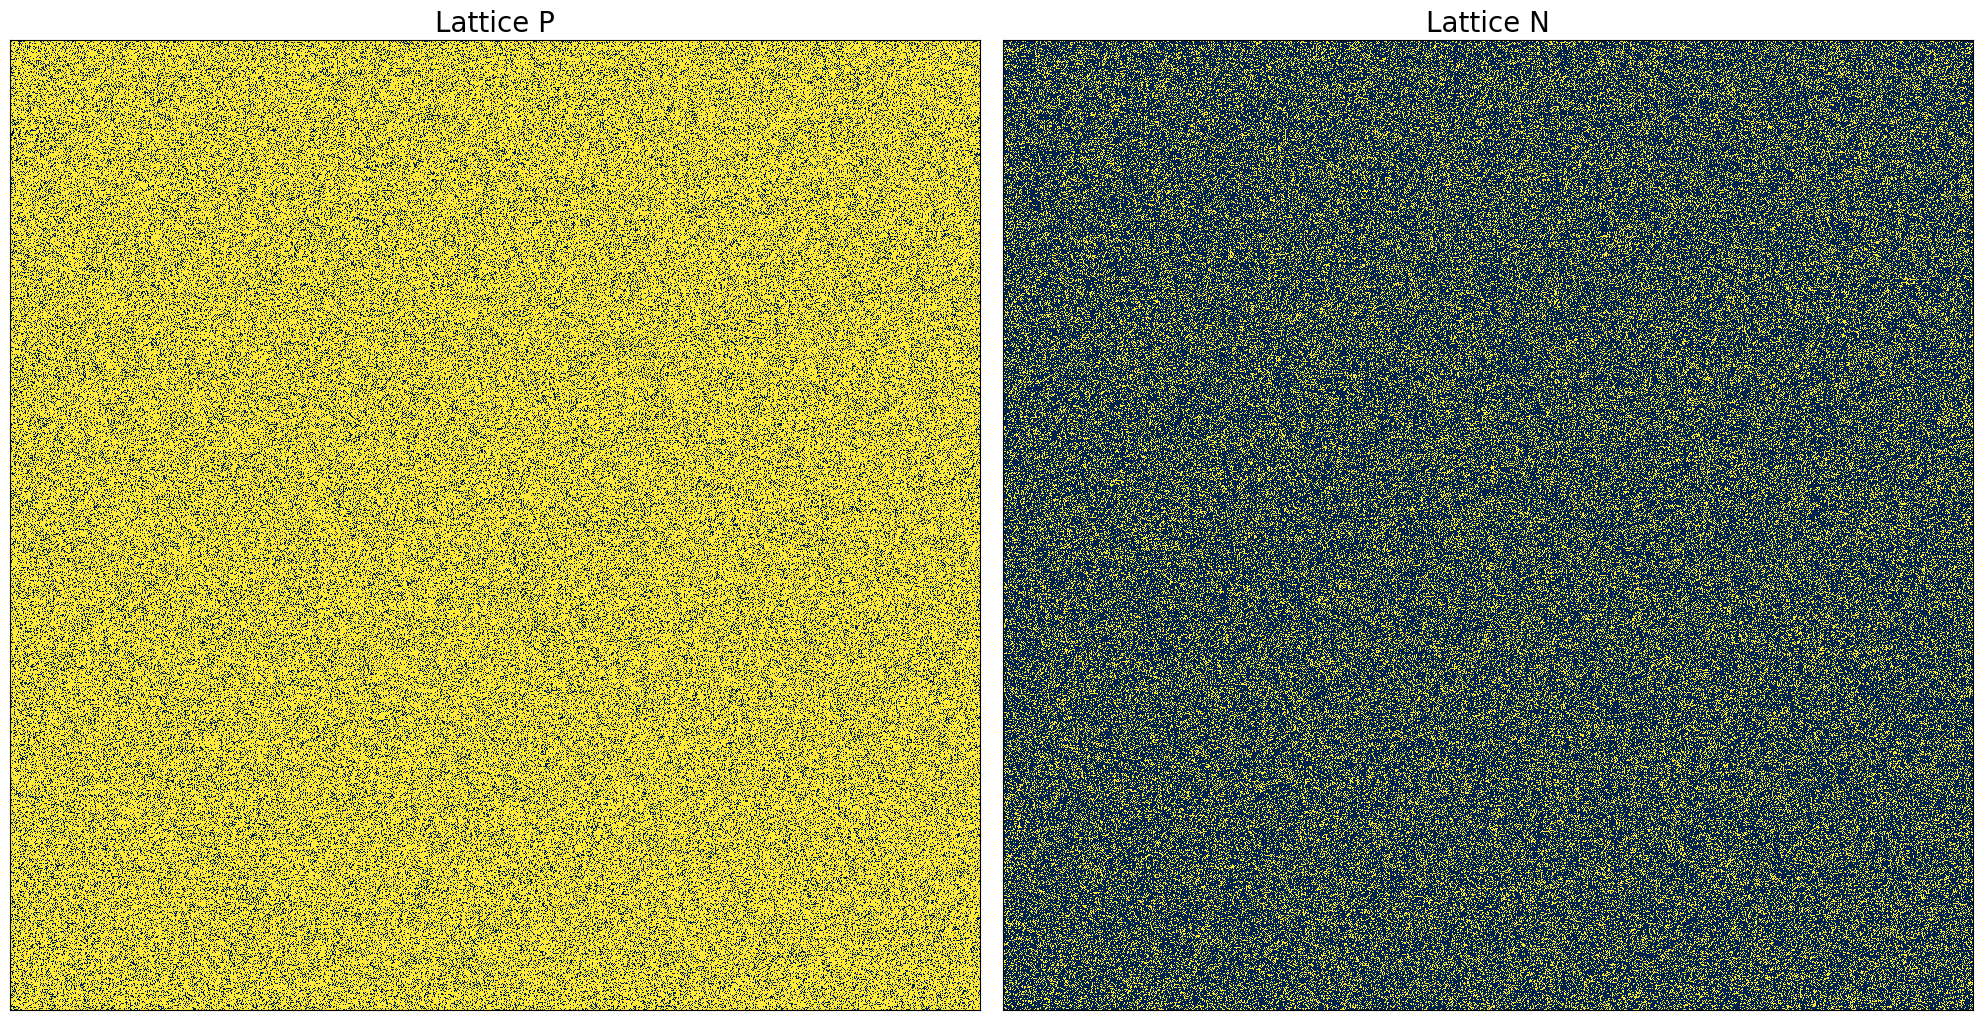

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# lattice_p
axs[0].pcolormesh(lattice_p.cpu(), cmap='cividis')
axs[0].set_title('Lattice P', fontsize=20)
axs[0].set_aspect('equal')
axs[0].set_xticks([])
axs[0].set_yticks([])

# lattice_n
axs[1].pcolormesh(lattice_n.cpu(), cmap='cividis')
axs[1].set_title('Lattice N', fontsize=20)
axs[1].set_aspect('equal')
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()

In [5]:
def get_energy_arr(lattices):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattices * conv2d(lattices, kern, padding='same')
    return arr
    
def get_energy(lattices):
    # applies the nearest neighbours summation
    return get_energy_arr(lattices).sum(axis=(1,2,3))

def get_dE_arr(lattices):
    return -2*get_energy_arr(lattices)

In [6]:
# This creates a batch of 2 lattices, we could have more
lattices = torch.stack([lattice_n, lattice_p]).unsqueeze(dim=1)
lattices.shape

torch.Size([2, 1, 1000, 1000])

In [7]:
# This calculates the energy of each lattice in the batch at the same time
get_energy_arr(lattices).shape

torch.Size([2, 1, 1000, 1000])

In [8]:
get_energy(lattices).shape

torch.Size([2])

In [9]:
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3))/N**2)
        
    return torch.vstack(avg_spins), torch.vstack(energies)

In [10]:
# energies and spins for both the lattices
BJs = 0.5*torch.ones(lattices.shape[0]).to(device)
spins, energies = metropolis(lattices, 1000, BJs)

spins_n = spins[:, 0].cpu().numpy()
energies_n = energies[:, 0].cpu().numpy()
spins_p = spins[:, 1].cpu().numpy()
energies_p = energies[:, 1].cpu().numpy()

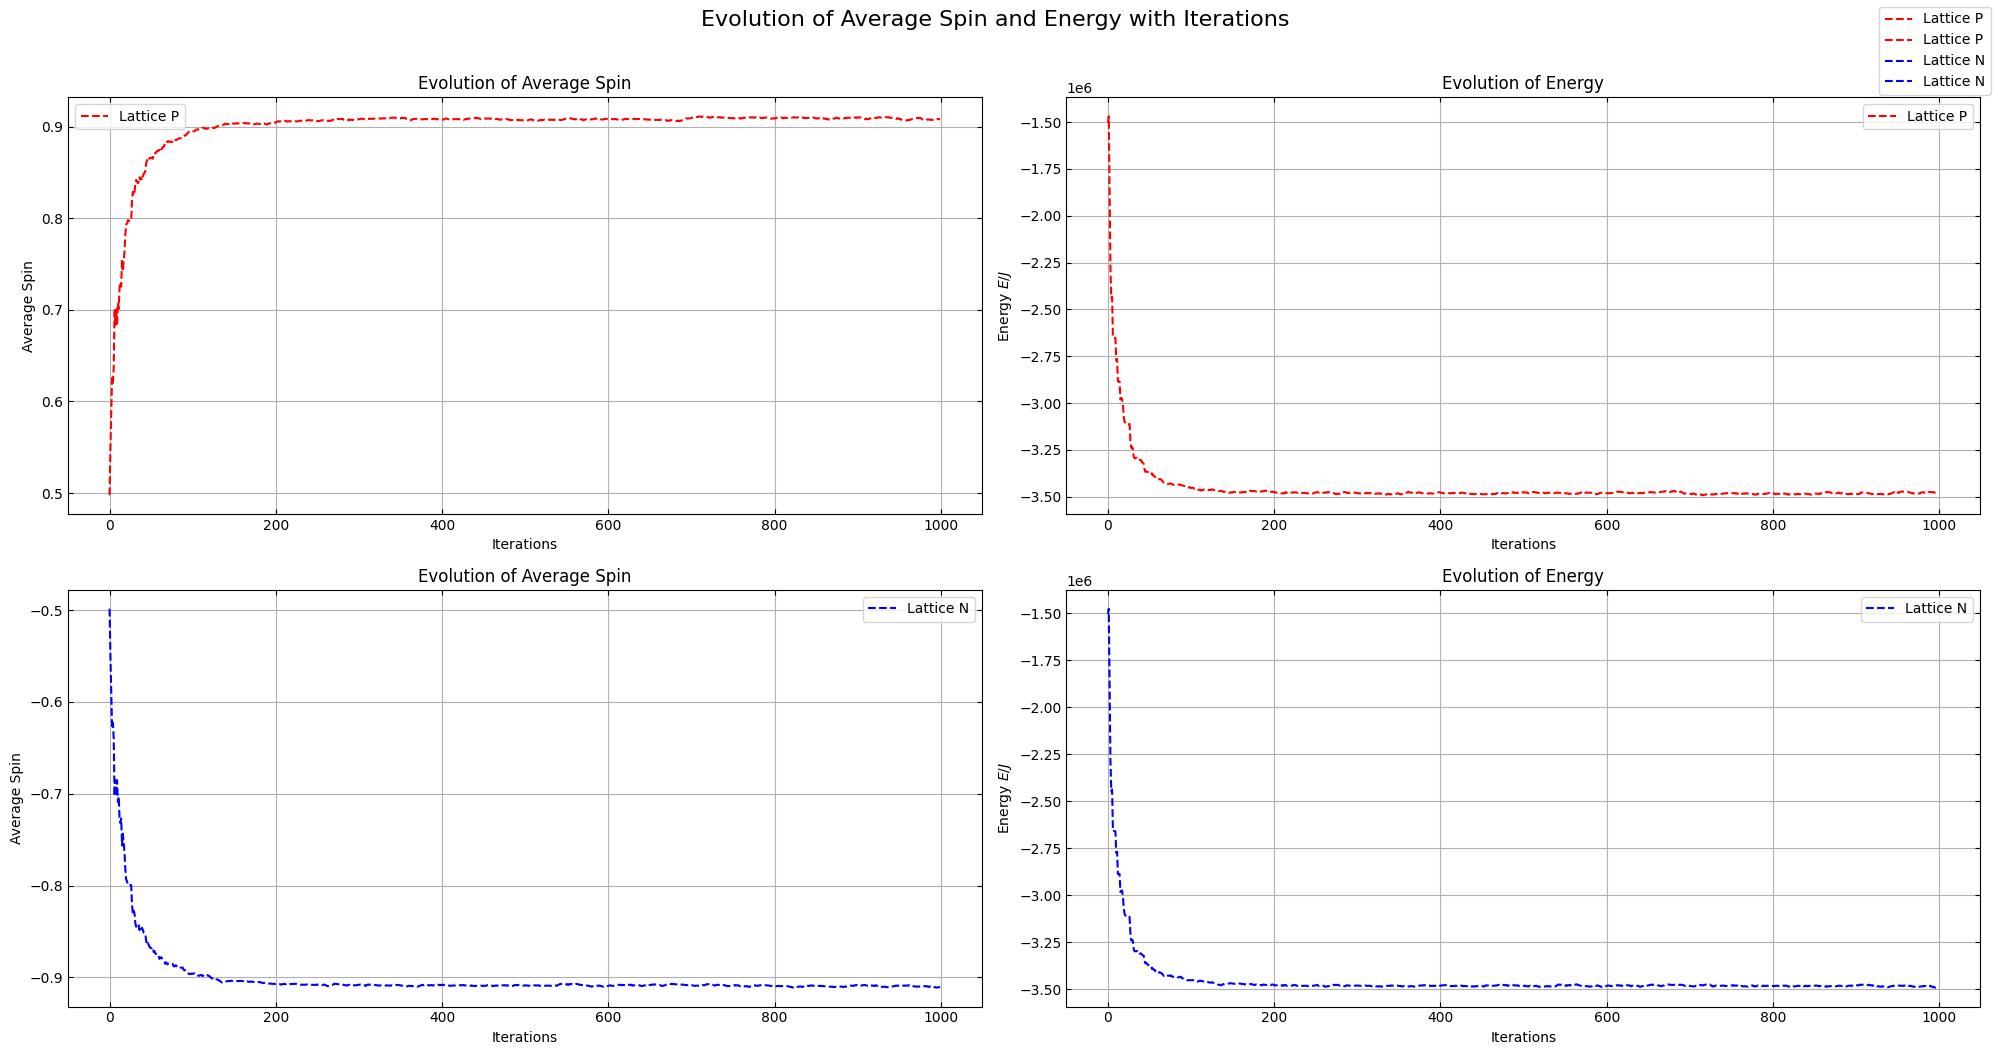

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# average spin and energies for lattice_p
ax = axes[0][0]
ax.plot(spins_p, '--r', label='Lattice P')
ax.set_xlabel('Iterations')
ax.set_ylabel('Average Spin')
ax.grid(True)
ax.set_title('Evolution of Average Spin')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.legend()

ax = axes[0][1]
ax.plot(energies_p, '--r', label='Lattice P')
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy $E/J$')
ax.grid(True)
ax.set_title('Evolution of Energy')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.legend()

# average spin and energies for lattice_n
ax = axes[1][0]
ax.plot(spins_n, '--b', label='Lattice N')
ax.set_xlabel('Iterations')
ax.set_ylabel('Average Spin')
ax.grid(True)
ax.set_title('Evolution of Average Spin')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.legend()

ax = axes[1][1]
ax.plot(energies_n, '--b', label='Lattice N')
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy $E/J$')
ax.grid(True)
ax.set_title('Evolution of Energy')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.legend()

fig.tight_layout()
fig.suptitle('Evolution of Average Spin and Energy with Iterations', y=1.05, size=16)
fig.legend()
plt.show()

## Heat Capacity and Susceptibility in the Ising Model

The Ising model is a mathematical model used to study the behavior of magnetic materials. By employing the Metropolis algorithm, we can simulate the Ising model and calculate various thermodynamic quantities. Two important quantities of interest are the heat capacity ($C_V$) and susceptibility ($\chi$), which provide insights into the system's behavior.

### Heat Capacity ($C_V$)

The heat capacity is a measure of how the energy of a system changes with temperature. It can be calculated using the formula:

$$C_V = σ_E^2 / T^2$$

Alternatively, in terms of the average energy, it can be expressed as:

$$C_V = (⟨(E/J)^2⟩ - ⟨E/J⟩^2) * (βJ)^2 * k^2$$

where $\sigma_E$ is the standard deviation of the energy, $⟨(\frac{E}{J})^2⟩$ is the average of the squared energy, ⟨$\frac{E}{J}$⟩ is the average energy, $\beta = \frac{1}{KT}$, J is the coupling constant, and k is Boltzmann's constant.

### Susceptibility (χ)

The susceptibility measures the system's response to an external magnetic field. It can be calculated as:

$$\chi = \frac{\sigma_m^2}{T} $$

where $\sigma_m$ is the standard deviation of the magnetization.

### Average Magnetization ($\vec{m}$) and Average Energy ($\vec{E}$)

The average magnetization ($\vec{m}$) is the average value of the magnetization over time, while the average energy ($\vec{E}$) is the average value of the energy over time.

In [12]:
def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    spins_std = torch.std(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, spins_std, energies_avg, energies_std

BJs = 1/torch.linspace(1, 3, 20).to(device)
spins_avg_n, spins_std_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
spins_avg_p, spins_std_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

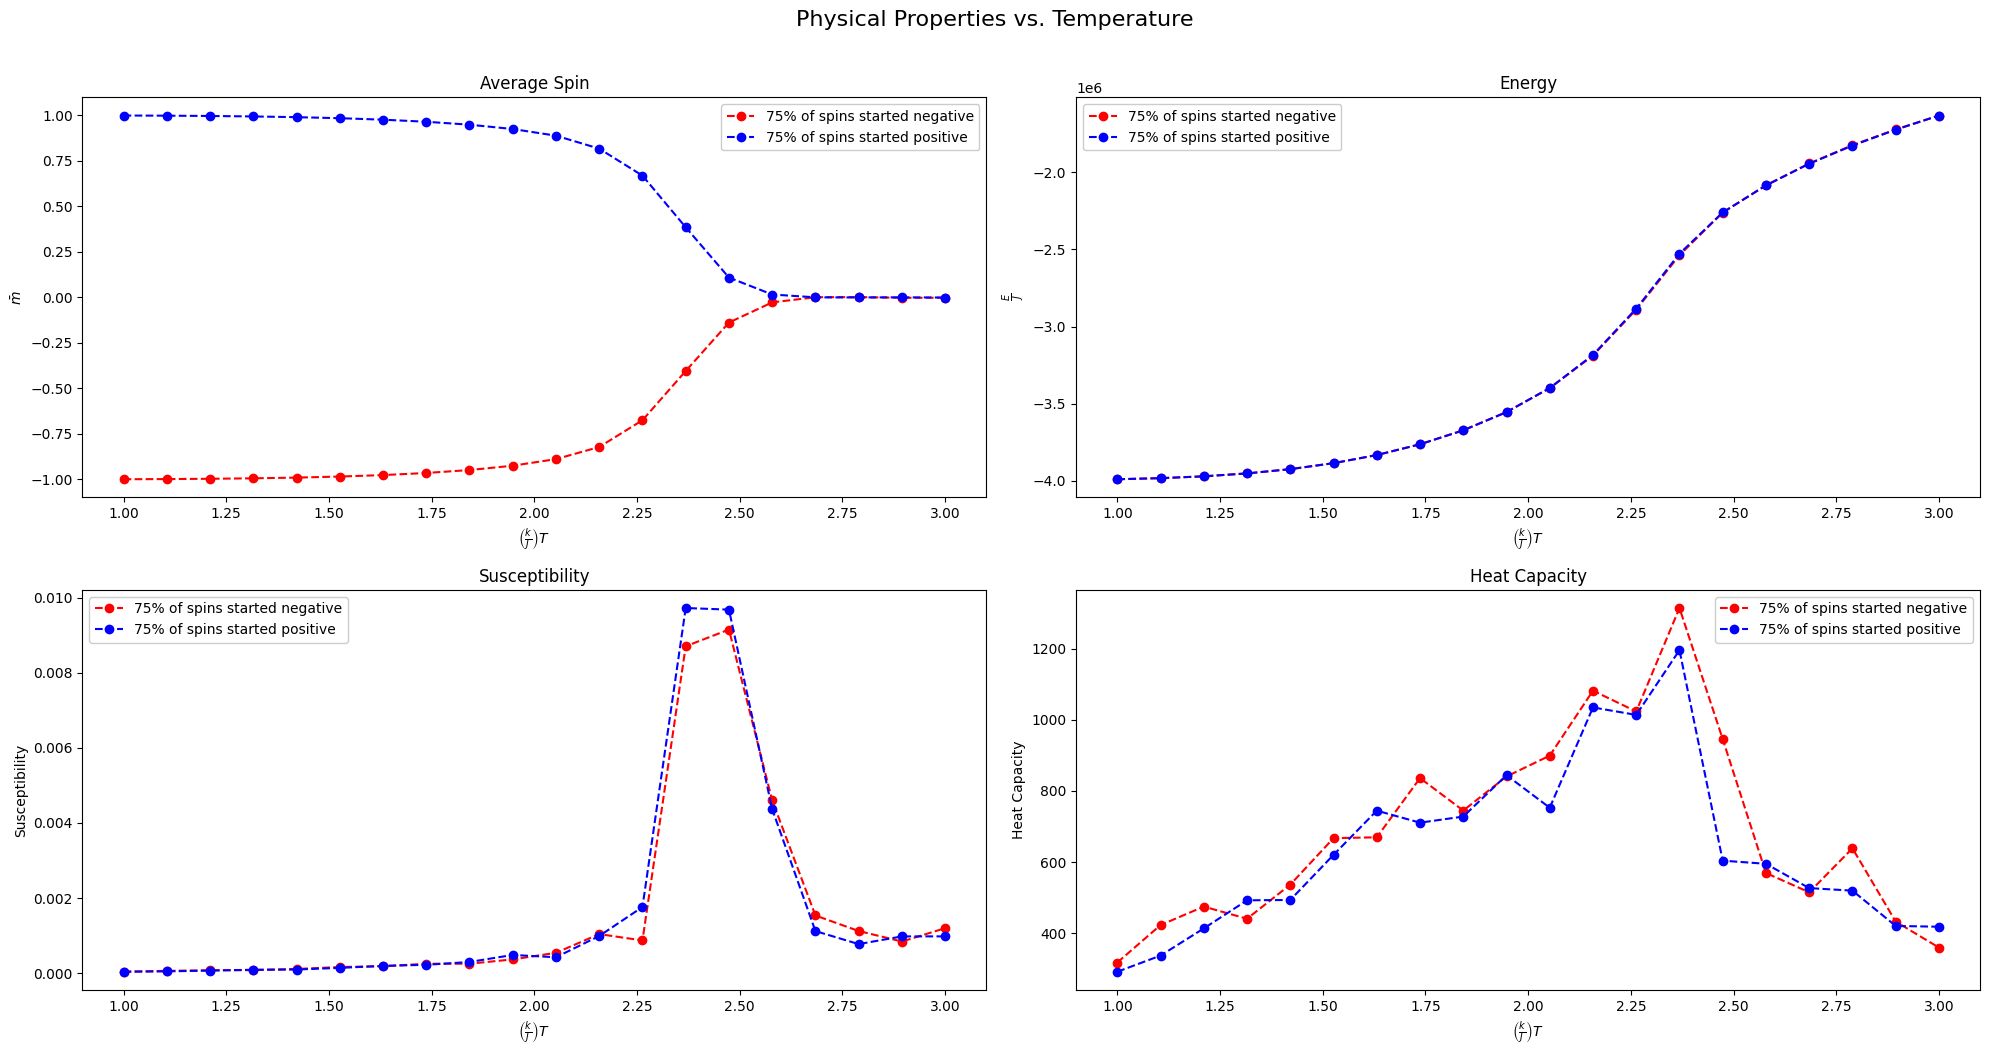

In [13]:
spins_avg_n, spins_std_n, E_means_n, E_stds_n = spins_avg_n.cpu().numpy(), spins_std_n.cpu().numpy(), E_means_n.cpu().numpy(), E_stds_n.cpu().numpy()
spins_avg_p, spins_std_p, E_means_p, E_stds_p = spins_avg_p.cpu().numpy(), spins_std_p.cpu().numpy(), E_means_p.cpu().numpy(), E_stds_p.cpu().numpy()
BJs = BJs.cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Average spin subplot
ax_spin = axes[0, 0]
ax_spin.plot(1 / BJs, spins_avg_n, 'o--', c = 'r', label='75% of spins started negative')
ax_spin.plot(1 / BJs, spins_avg_p, 'o--', c = 'b', label='75% of spins started positive')
ax_spin.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_spin.set_ylabel(r'$\bar{m}$')
ax_spin.legend(facecolor='white', framealpha=1)
ax_spin.set_title('Average Spin')

# Energy subplot
ax_energy = axes[0, 1]
ax_energy.plot(1 / BJs, E_means_n, 'o--', c = 'r', label='75% of spins started negative')
ax_energy.plot(1 / BJs, E_means_p, 'o--', c = 'b', label='75% of spins started positive')
ax_energy.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_energy.set_ylabel(r'$\frac{E}{J}$')
ax_energy.legend(facecolor='white', framealpha=1)
ax_energy.set_title('Energy')

# Susceptibility subplot
ax_susceptibility = axes[1, 0]
ax_susceptibility.plot(1 / BJs, spins_std_n*BJs, 'o--', c = 'r', label='75% of spins started negative')
ax_susceptibility.plot(1 / BJs, spins_std_p*BJs, 'o--', c = 'b', label='75% of spins started positive')
ax_susceptibility.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_susceptibility.set_ylabel('Susceptibility')
ax_susceptibility.legend(facecolor='white', framealpha=1)
ax_susceptibility.set_title('Susceptibility')

# Heat Capacity subplot
ax_heat_capacity = axes[1, 1]
ax_heat_capacity.plot(1 / BJs, E_stds_n*BJs*BJs, 'o--', c = 'r', label='75% of spins started negative')
ax_heat_capacity.plot(1 / BJs, E_stds_p*BJs*BJs, 'o--', c = 'b', label='75% of spins started positive')
ax_heat_capacity.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_heat_capacity.set_ylabel('Heat Capacity')
ax_heat_capacity.legend(facecolor='white', framealpha=1)
ax_heat_capacity.set_title('Heat Capacity')

fig.tight_layout()
fig.suptitle('Physical Properties vs. Temperature', y=1.05, size=16)
plt.show()

# The 3D Ising Model

In [3]:
# lattice size 150 x 150 x 150
N = 150

In [4]:
init_random = torch.rand((N,N,N)).to(device)
lattice_p = torch.zeros((N,N,N)).to(device)
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

In [5]:
def get_energy_arr(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(3, 1) 
    kern[1][1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattice * conv3d(lattice, kern, padding='same')
    return arr
    
def get_energy(lattice):
    # applies the nearest neighbours summation
    return get_energy_arr(lattice).sum(axis=(2,3,4)).squeeze()

def get_dE_arr(lattice):
    return -2*get_energy_arr(lattice)

In [6]:
lattices = torch.stack([lattice_p, lattice_p]).unsqueeze(dim=1)
lattices.shape

torch.Size([2, 1, 150, 150, 150])

In [7]:
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        k = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2,k::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2,k::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3,4))/N**3)
    return torch.vstack(avg_spins), torch.vstack(energies)

In [8]:
def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    spins_std = torch.std(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, spins_std, energies_avg, energies_std

BJs = 1/torch.linspace(3, 5.5, 20).to(device)
spins_avg_p, spins_std_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

# Validation
The accepted value for the critical temperature in the 3D Ising model, as indicated in the research paper mentioned (https://arxiv.org/abs/2205.12357), is given by $\beta J = 0.221654626$.

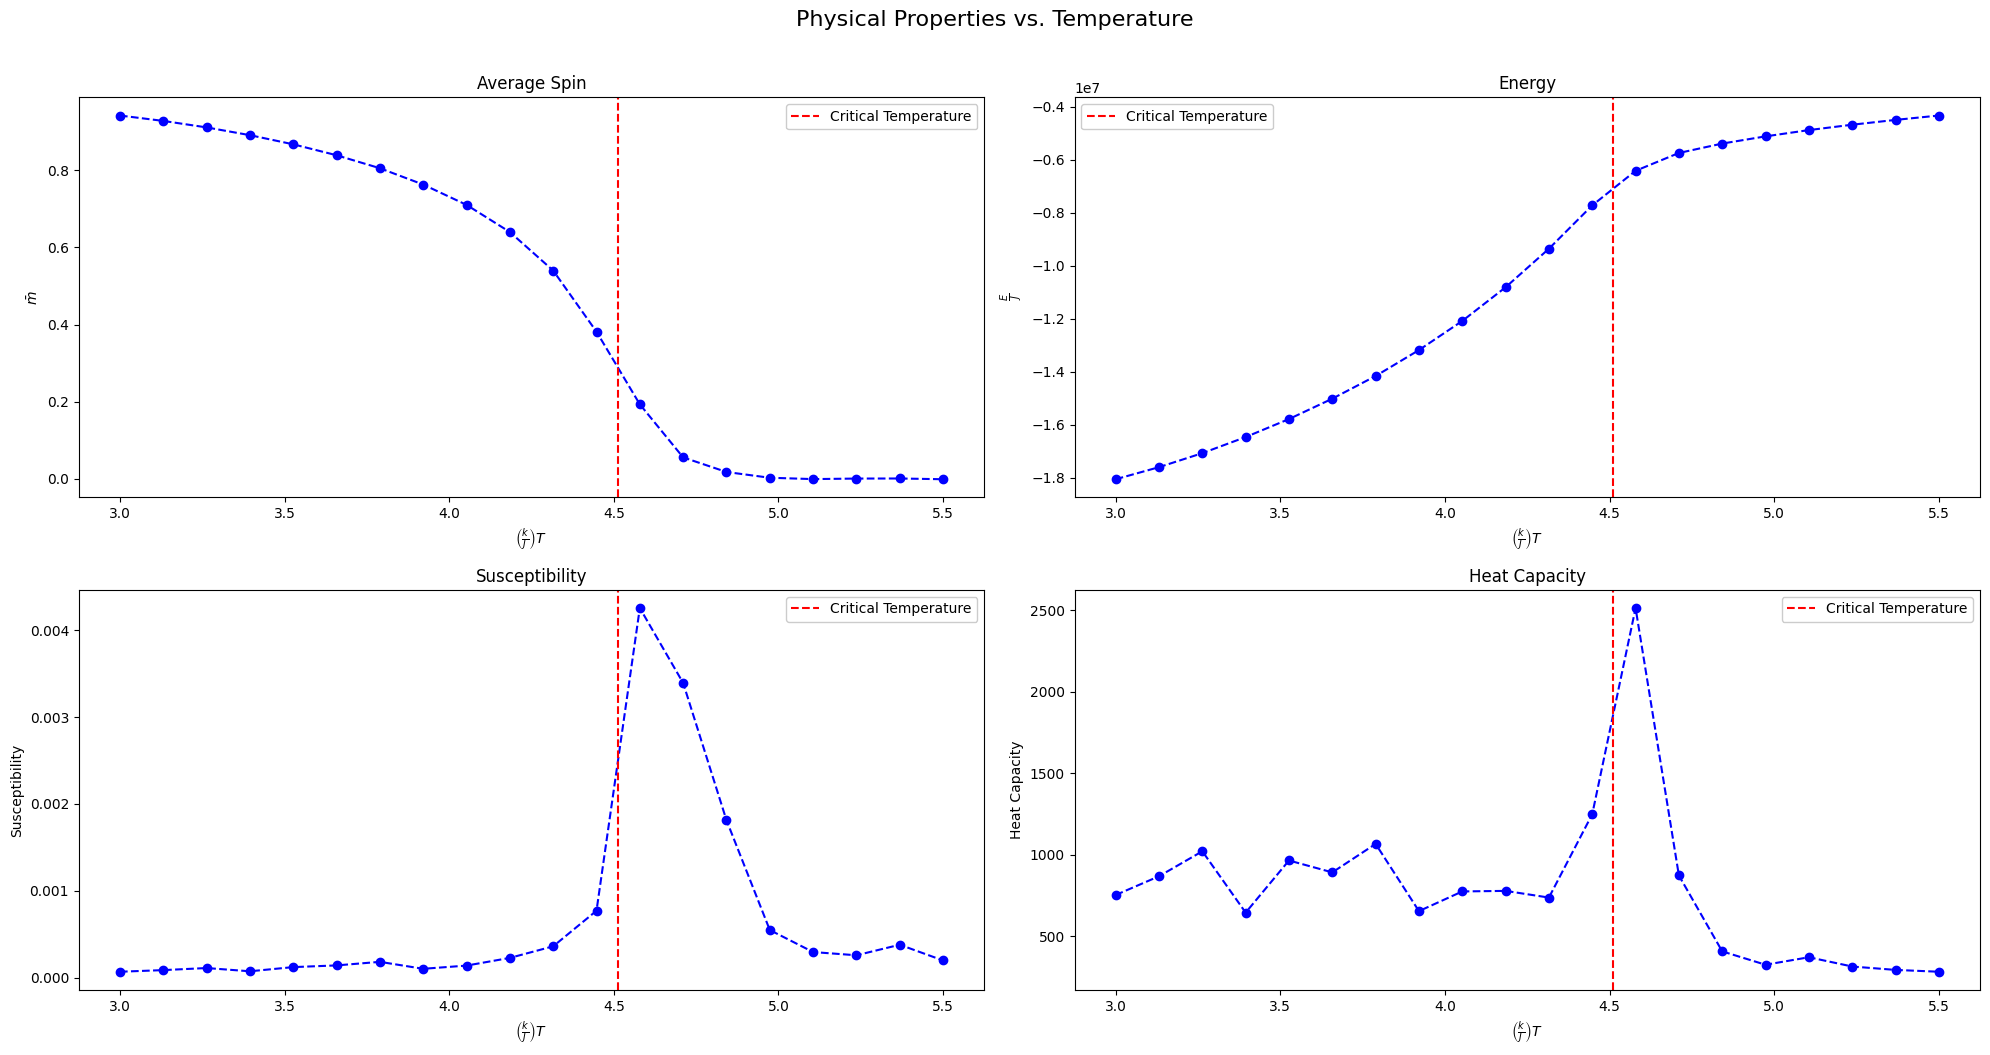

In [9]:
spins_avg_p, spins_std_p, E_means_p, E_stds_p = spins_avg_p.cpu().numpy(), spins_std_p.cpu().numpy(), E_means_p.cpu().numpy(), E_stds_p.cpu().numpy()
BJs = BJs.cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Average spin subplot
ax_spin = axes[0, 0]
ax_spin.plot(1 / BJs, spins_avg_p, 'o--', c = 'b')
ax_spin.axvline(1/0.221654626, c='r', ls = '--', label='Critical Temperature')
ax_spin.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_spin.set_ylabel(r'$\bar{m}$')
ax_spin.legend(facecolor='white', framealpha=1)
ax_spin.set_title('Average Spin')

# Energy subplot
ax_energy = axes[0, 1]
ax_energy.plot(1 / BJs, E_means_p, 'o--', c = 'b')
ax_energy.axvline(1/0.221654626, c='r', ls = '--', label='Critical Temperature')
ax_energy.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_energy.set_ylabel(r'$\frac{E}{J}$')
ax_energy.legend(facecolor='white', framealpha=1)
ax_energy.set_title('Energy')

# Susceptibility subplot
ax_susceptibility = axes[1, 0]
ax_susceptibility.plot(1 / BJs, spins_std_p*BJs, 'o--', c = 'b')
ax_susceptibility.axvline(1/0.221654626, c='r', ls = '--', label='Critical Temperature')
ax_susceptibility.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_susceptibility.set_ylabel('Susceptibility')
ax_susceptibility.legend(facecolor='white', framealpha=1)
ax_susceptibility.set_title('Susceptibility')

# Heat Capacity subplot
ax_heat_capacity = axes[1, 1]
ax_heat_capacity.plot(1 / BJs, E_stds_p*BJs*BJs, 'o--', c = 'b')
ax_heat_capacity.axvline(1/0.221654626, c='r', ls = '--', label='Critical Temperature')
ax_heat_capacity.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_heat_capacity.set_ylabel('Heat Capacity')
ax_heat_capacity.legend(facecolor='white', framealpha=1)
ax_heat_capacity.set_title('Heat Capacity')

fig.tight_layout()
fig.suptitle('Physical Properties vs. Temperature', y=1.05, size=16)
plt.show()